In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Install the 'timm' library for working with pre-trained models and 'faiss-gpu' for GPU-accelerated similarity search.

!pip install timm faiss-gpu


In [25]:
# Standard Libraries
import time
import os
import matplotlib.pyplot as plt
import copy

# NumPy and Pandas
import numpy as np
import pandas as pd

# PyTorch and related modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

# torchvision for image-related operations
import torchvision
from torchvision import transforms, datasets

# timm for working with pre-trained models
import timm

In [26]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("timm version:", timm.__version__)
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

NumPy version: 1.23.5
Pandas version: 1.5.3
timm version: 0.9.7
PyTorch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [27]:
!unzip '/content/drive/MyDrive/DL Labs/dataset.zip'

Archive:  /content/drive/MyDrive/DL Labs/dataset.zip
replace Human Action Detection with Artificial Intelligence.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [32]:
# Define data transformations for training and testing data
transformations = {
    'train': transforms.Compose([
        # Randomly resize and crop the image to 224x224 pixels
        transforms.RandomResizedCrop(224),
        # Randomly flip the image horizontally for data augmentation
        transforms.RandomHorizontalFlip(),
        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),
        # Normalize the image with mean and standard deviation values
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Specify the directory containing the dataset
data_directory = '../content/emirhan_human_dataset/datasets/human_data/'

# Create datasets for training and testing data with the specified transformations
datasets = {
    'train': datasets.ImageFolder(os.path.join(data_directory, 'train_data'), transformations['train']),
    'test': datasets.ImageFolder(os.path.join(data_directory, 'test_data'), transformations['test'])
}

# Create data loaders for training and testing data
dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=4, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(datasets['test'], batch_size=4, shuffle=True, num_workers=4)
}

# Get the sizes of the training and testing datasets
dataset_sizes = {
    'train': len(datasets['train']),
    'test': len(datasets['test'])
}

# Get the class names based on the training dataset
class_names = datasets['train'].classes

# Check if GPU (cuda) is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


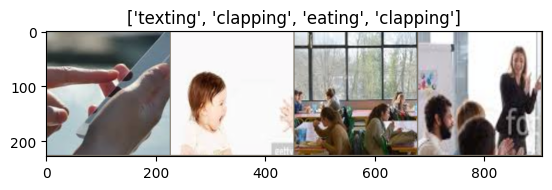

In [33]:

# Function to display an image batch
def show_images(tensor_images, title=None):
    """Display a batch of Tensor images."""
    tensor_images = tensor_images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # Mean values used for normalization
    std = np.array([0.229, 0.224, 0.225])    # Standard deviation values used for normalization
    tensor_images = std * tensor_images + mean  # De-normalize the image
    tensor_images = np.clip(tensor_images, 0, 1)  # Clip values to the range [0, 1]
    plt.imshow(tensor_images)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
batch_inputs, batch_classes = next(iter(dataloaders['train']))

# Make a grid from the batch of images
grid_images = torchvision.utils.make_grid(batch_inputs)

# Display the batch of images with their corresponding class names
show_images(grid_images, title=[class_names[x] for x in batch_classes])


In [34]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    start_time = time.time()

    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_inputs, batch_labels in dataloaders[phase]:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    batch_outputs = model(batch_inputs)
                    _, batch_preds = torch.max(batch_outputs, 1)
                    batch_loss = loss_fn(batch_outputs, batch_labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        batch_loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += batch_loss.item() * batch_inputs.size(0)
                running_corrects += torch.sum(batch_preds == batch_labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            # Deep copy the model
            if phase == 'test' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())

        print()

    elapsed_time = time.time() - start_time
    print(f'Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')
    print(f'Best Validation Acc: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model


In [35]:
def visualize_model(model_to_visualize, num_images=6):
    # Save the original training mode of the model
    original_training_mode = model_to_visualize.training

    # Set the model to evaluation mode (no gradient computation)
    model_to_visualize.eval()

    # Counter for the number of images displayed
    images_displayed = 0

    # Create a new figure for displaying images
    fig = plt.figure()

    # Iterate through the test dataloader
    with torch.no_grad():
        for i, (batch_inputs, batch_labels) in enumerate(dataloaders['test']):
            # Move batch_inputs and batch_labels to the specified device (CPU or GPU)
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass through the model to get predictions
            batch_outputs = model_to_visualize(batch_inputs)
            _, batch_preds = torch.max(batch_outputs, 1)

            # Iterate through the batch of images
            for j in range(batch_inputs.size()[0]):
                images_displayed += 1
                # Create a subplot for each image
                ax = plt.subplot(num_images // 2, 2, images_displayed)
                ax.axis('off')
                # Set the title to the predicted class name
                ax.set_title(f'Predicted: {class_names[batch_preds[j]]}')
                # Display the image using the 'show_images' function
                show_images(batch_inputs.cpu().data[j])

                # Check if the desired number of images to display has been reached
                if images_displayed == num_images:
                    # Restore the model's training mode (if it was training)
                    model_to_visualize.train(mode=original_training_mode)
                    return

    # Restore the model's training mode (if it was training)
    model_to_visualize.train(mode=original_training_mode)


In [37]:
import timm

# Create an EfficientNetV2 model with specified parameters
efficientnet_model = timm.create_model("tf_efficientnetv2_s_in21ft1k", pretrained=True, drop_rate=0.3, num_classes=len(class_names))

# Move the model to the specified device (CPU or GPU)
efficientnet_model = efficientnet_model.to(device)

# Define the loss function (criterion)
loss_criterion = nn.CrossEntropyLoss()

# Specify the optimizer for training (Stochastic Gradient Descent - SGD)
optimizer_efficientnet = optim.SGD(efficientnet_model.parameters(), lr=0.001, momentum=0.9)

# Decay the learning rate by a factor of 0.1 every 7 epochs
learning_rate_scheduler = lr_scheduler.StepLR(optimizer_efficientnet, step_size=7, gamma=0.1)


In [39]:
# Train the 'efficientnet_model' using the specified criterion (loss function), optimizer, and learning rate scheduler
# for a total of 10 epochs
trained_efficientnet_model = train_model(efficientnet_model, loss_criterion, optimizer_efficientnet, learning_rate_scheduler, num_epochs=10)


Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 1.7880 Acc: 0.4380
Test Loss: 0.8688 Acc: 0.7353

Epoch 1/9
----------
Train Loss: 1.3274 Acc: 0.5917
Test Loss: 0.7438 Acc: 0.7830

Epoch 2/9
----------
Train Loss: 1.1724 Acc: 0.6401
Test Loss: 0.6951 Acc: 0.7950

Epoch 3/9
----------
Train Loss: 1.0799 Acc: 0.6651
Test Loss: 0.7202 Acc: 0.7990

Epoch 4/9
----------
Train Loss: 0.9903 Acc: 0.6901
Test Loss: 0.6853 Acc: 0.7870

Epoch 5/9
----------
Train Loss: 0.9474 Acc: 0.7036
Test Loss: 0.6631 Acc: 0.8020

Epoch 6/9
----------
Train Loss: 0.9033 Acc: 0.7143
Test Loss: 0.5933 Acc: 0.8217

Epoch 7/9
----------
Train Loss: 0.7971 Acc: 0.7461
Test Loss: 0.5713 Acc: 0.8277

Epoch 8/9
----------
Train Loss: 0.7687 Acc: 0.7585
Test Loss: 0.5675 Acc: 0.8277

Epoch 9/9
----------
Train Loss: 0.7578 Acc: 0.7604
Test Loss: 0.5639 Acc: 0.8293

Training complete in 58m 7s
Best Validation Acc: 0.8293


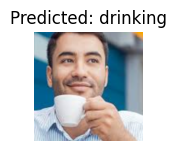

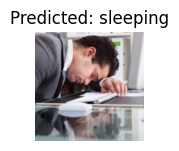

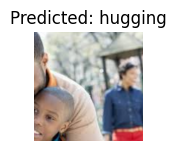

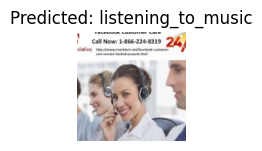

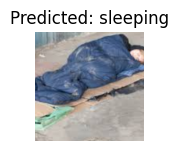

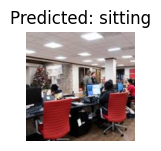

In [41]:
visualize_model(trained_efficientnet_model)

plt.ioff()
plt.show()